In [2]:
# PARTE RAQUEL

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score, f1_score
from cleanlab.filter import find_label_issues
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import geopandas as gpd # For .shp and .geoJSON files
import seaborn as sns

In [3]:
folder = ''
df = pd.read_csv(folder+'AllData.csv', index_col='CVEGEO')
df_id = df[['NOM_ENT','NOM_MUN']].copy()
df = df.drop(columns=['NOM_ENT','NOM_MUN'])
print(len(df))
df.head()

2469


,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,agua_AR,agua_FC,agua_PT,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,semaforo
CVEGEO,,,,,,,,,,,,,
1001,948990,1918.046196,116635.92480,57.80700,4.829056,91,226,24,0.900702,21,24.193751,44.979780,Rojo
1002,51536,2030.520325,54337.42660,60.05970,4.274541,0,54,9,0.904023,0,4.500000,2.083333,Verde
1003,58250,1827.143813,92335.78323,60.71769,1.158972,7,43,4,0.787156,3,2.333333,2.835498,Rojo
1004,17000,1967.656566,12838.35445,52.22142,3.153082,10,13,3,0.912407,0,0.000000,1.000000,Rojo
1005,129929,1936.513072,49989.50916,58.46688,3.357602,34,42,16,0.798126,3,23.113636,80.622222,Rojo


In [6]:
#Defining function for plotting

def viz_on_map(df, alpha_col = None, color_col = 'semaforo', color_map = {
    'Rojo': 'red',
    'Amarillo': 'gold',
    'Verde': 'green'},
    title ='Water Quality Indicator by Municipality with Confidence-Based Transparency'):
    ''' This function makes a previev of the column 'semaforo' on the map of Mexico '''

    municipios_path = 'mun22gw/mun22gw.shp'
    municipios = gpd.read_file(municipios_path)
    municipios['CVEGEO'] = municipios['CVEGEO'].astype(int)
    mun_geo = municipios[['CVEGEO','geometry']].set_index('CVEGEO')
    if alpha_col:
        columns_to_plot = [alpha_col,color_col]
    else:
        columns_to_plot = color_col
    df = mun_geo.merge(df[columns_to_plot], how = 'outer', left_on='CVEGEO', right_index=True)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 7))

    # 1. First plot all geometries with full opacity (for borders)
    df.boundary.plot(ax=ax, color='black', linewidth=0.2)

    # 2. Create a new column for plotting colors
    df['plot_color'] = df[color_col].map(color_map).fillna('gray')

    # 3. Plot with confidence-based alpha
    for class_name in color_map.keys():
        # Filter features for this class
        class_data = df[df[color_col] == class_name]
        if not class_data.empty:
            # Plot with variable alpha
            if alpha_col is not None:
                class_data.plot(
                    ax=ax,
                    color=class_data['plot_color'],
                    alpha=class_data[alpha_col].fillna(0),  # Use confidence for alpha
                    edgecolor='none',
                    label=class_name)
            else:
                class_data.plot(
                    ax=ax,
                    color=class_data['plot_color'],
                    edgecolor='none',
                    label=class_name)

    # 4. Create custom legend
    legend_elements = []
    for class_name, color in color_map.items():
        legend_elements.append(mpatches.Patch(
            color=color,
            label=class_name,
            alpha=1.0
        ))
    
    if alpha_col is not None:
        # Add confidence explanation
        confidence_elements = [
            mpatches.Patch(color='gray', alpha=0.3, label='Low Confidence (~50%)'),
            mpatches.Patch(color='gray', alpha=0.6, label='Medium Confidence (~70%)'),
            mpatches.Patch(color='gray', alpha=1, label='High Confidence (~100%)')
            ]
        ax.legend(
            handles=legend_elements + confidence_elements,
            title='Semaforo Classes & Confidence',
            loc='upper right'
    )
    else:
        ax.legend(
            handles=legend_elements,
            title='Semaforo Classes & Confidence',
            loc='upper right'
        )
        title ='Water Quality Indicator by Municipality'

    plt.title(title)
    plt.tight_layout()
    plt.show()

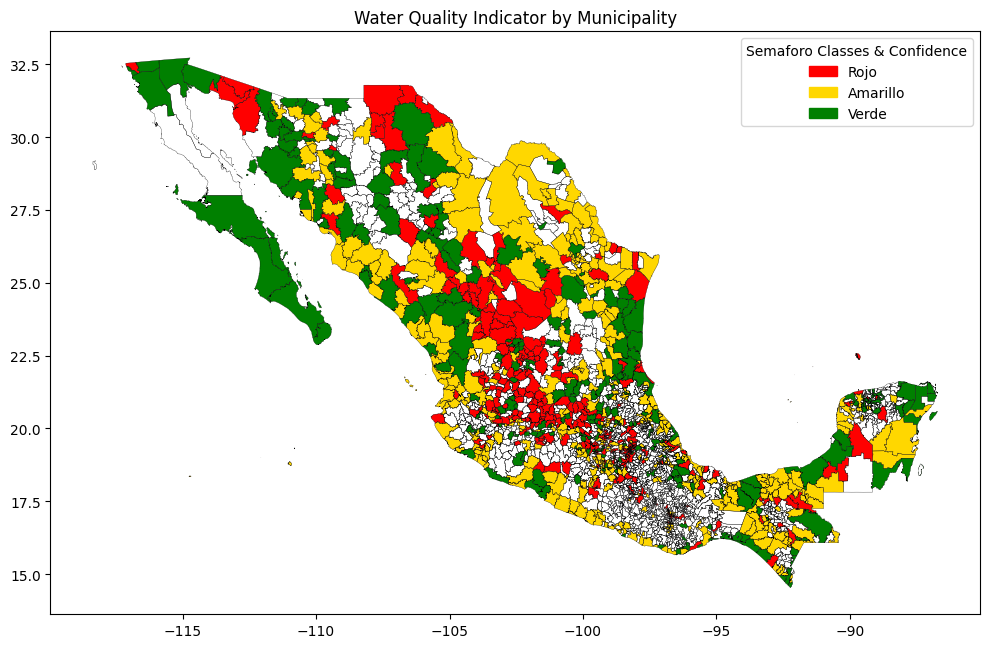

In [5]:
viz_on_map(df)

In [6]:
X_data = df.drop('semaforo',axis = 1)
y_data = df['semaforo']

In [7]:
print(len(y_data))
print(len(y_data[y_data.isna()]))
print(len(y_data)-len(y_data[y_data.isna()]))

2469
1423
1046


In [ ]:

from sklearn.model_selection import train_test_split

def create_validation_dataset(df, target_col='semaforo', test_size=0.2, 
                            random_state=22, stratify=True):
    """
    Creates validation dataset using scikit-learn's train_test_split with stratification.
    
    Args:
        df: Input DataFrame or GeoDataFrame
        target_col: Column with values to mask (default 'semaforo')
        test_size: Proportion of values to mask (default 0.2)
        random_state: Random seed for reproducibility
        stratify: Whether to stratify by target_col (default True)
        
    Returns:
        modified_df: DataFrame with some values masked
        testing_values: Series with original masked values (preserves index)
    """
    # Make a copy to avoid modifying original
    df_working = df.copy()
    
    # Identify non-null values
    known_mask = df_working[target_col].notna()
    known_data = df_working[known_mask]
    
    # Prepare stratification if requested
    stratify_col = known_data[target_col] if stratify else None
    
    # Split using sklearn's train_test_split
    _, test_idx = train_test_split(
        known_data.index,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_col
    )
    
    # Save original values before masking
    testing_values = df_working.loc[test_idx, target_col].copy()
    
    # Set selected values to NaN
    df_working.loc[test_idx, target_col] = np.nan
    
    return df_working, testing_values

In [209]:
class RobustMultiModelNaNClassifier:
    def __init__(self, models=None, moldel_confidence_threshold=0.60, 
                 label_prediction_threshold=0.90, max_iterations=25):
        """
        Enhanced classifier that operates directly on 'semaforo' column.
        
        Args:
            models: List of classifier models (odd number recommended)
            confidence_threshold: Threshold for accepting ensemble predictions
            prediction_threshold: Threshold for keeping final predictions
            max_iterations: Maximum number of iterations
        """
        # Default robust models for noisy data
        if models is None:
            self.models = [
                CatBoostClassifier(iterations=500, class_weights={0: 0.42, 1: 0.31, 2: .27}, verbose=0),
                XGBClassifier(max_depth=5, reg_alpha=1),
                RandomForestClassifier(max_samples=0.5, class_weight={0: 0.42, 1: 0.31, 2: .27})
            ]
        else:
            if len(models) % 2 == 0:
                raise ValueError("Number of models must be odd for voting")
            self.models = models
            
        self.moldel_confidence_threshold = moldel_confidence_threshold
        self.label_prediction_threshold = label_prediction_threshold
        self.max_iterations = max_iterations
        self.label_encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.fitted_models = []
        self.feature_columns_ = None  # To store feature columns used in fitting
    
    def fit(self, X, y):
        """Fit all models on cleaned and scaled training data"""
        # Store feature columns to ensure consistent scaling later
        self.feature_columns_ = X.columns.tolist()
        
        # Scale numeric features (only the features, not target/confidence)
        X_scaled = self.scaler.fit_transform(X[self.feature_columns_])
        
        # Fit models
        self.fitted_models = []
        for model in self.models:
            try:
                model.fit(X_scaled, y)
            except Exception as e:
                print(f"Error fitting {model.__class__.__name__}: {str(e)}")
                continue
            self.fitted_models.append(model)
    
    def predict_with_confidence(self, X):
        """
        Predict using ensemble of models with confidence.
        Returns predictions and confidence scores.
        """
        # Only scale the features that were used in training
        X_scaled = self.scaler.transform(X[self.feature_columns_])
        
        all_probs = []
        for model in self.fitted_models:
            try:
                proba = model.predict_proba(X_scaled)
                all_probs.append(proba)
            except Exception as e:
                print(f"Prediction error with {model.__class__.__name__}: {str(e)}")
                continue
                
        if not all_probs:
            raise ValueError("No models produced valid predictions")
        
        # Average probabilities across models
        avg_probs = np.mean(all_probs, axis=0)
        
        # Get predictions and confidence
        predictions = np.argmax(avg_probs, axis=1)
        confidence = np.max(avg_probs, axis=1)
        
        return predictions, confidence
    
    def process_dataframe(self, df):
        """
        Process the dataframe to predict NaN values in 'semaforo' column.
        Returns modified dataframe and iteration count.
        """
        # Validate input
        if 'semaforo' not in df.columns:
            raise ValueError("Dataframe must contain 'semaforo' column")
            
        # Make a working copy (we'll modify the 'semaforo' column directly)
        df_working = df.copy()
        
        # Add confidence column and set known labels to 1.0
        df_working['confidence'] = np.where(
            df_working['semaforo'].notna(), 
            1.0,  # Full confidence for known labels
            np.nan  # NaN for unknown labels
        )
        
        # Encode labels only if there are valid labels
        valid_mask = df_working['semaforo'].notna()
        if valid_mask.sum() == 0:
            raise ValueError("No valid labels found in 'semaforo' column")
        
        self.label_encoder.fit(df_working.loc[valid_mask, 'semaforo'])
        
        # Track which rows have low confidence (need prediction)
        low_conf_mask = (df_working['confidence'] < self.label_prediction_threshold) | df_working['confidence'].isna()
        iteration = 0
        
        while low_conf_mask.any() and iteration < self.max_iterations:
            iteration += 1
            print(f"\nIteration {iteration}: {low_conf_mask.sum()} low confidence values remaining")
            
            # Prepare training data (high confidence rows)
            train_df = df_working[~low_conf_mask].copy()
            
            # Stratified split to maintain class balance
            train_subset, val_subset = train_test_split(
                train_df, 
                test_size=0.2, 
                random_state=42 + iteration,
                stratify=train_df['semaforo']
            )
            
            # Prepare features and target (only use feature columns)
            X_train = train_subset[self.feature_columns_] if self.feature_columns_ else train_subset.drop(columns=['semaforo', 'confidence'], errors='ignore')
            y_train = self.label_encoder.transform(train_subset['semaforo'])
            
            X_val = val_subset[self.feature_columns_] if self.feature_columns_ else val_subset.drop(columns=['semaforo', 'confidence'], errors='ignore')
            y_val = val_subset['semaforo']
            
            # Fit models
            self.fit(X_train, y_train)
            
            # Validate on held-out set
            val_pred_encoded, val_conf = self.predict_with_confidence(X_val)
            val_pred = self.label_encoder.inverse_transform(val_pred_encoded)
            
            # Calculate robust metrics
            val_bal_acc = balanced_accuracy_score(y_val, val_pred)
            val_f1 = f1_score(y_val, val_pred, average='weighted')
            avg_confidence = np.mean(val_conf)
            
            print(f"Validation Balanced Accuracy: {val_bal_acc:.2f}")
            print(f"Validation Weighted F1: {val_f1:.2f}")
            print(f"Avg Confidence: {avg_confidence:.2f}")
            
            # Only proceed if confidence threshold is met
            if avg_confidence < self.moldel_confidence_threshold:
                print("Confidence below threshold, stopping iteration")
                continue
                
            # Predict on low confidence rows
            X_predict = df_working[low_conf_mask][self.feature_columns_] if self.feature_columns_ else df_working[low_conf_mask].drop(columns=['semaforo', 'confidence'], errors='ignore')
            
            if not X_predict.empty:
                pred_encoded, pred_conf = self.predict_with_confidence(X_predict)
                pred_labels = self.label_encoder.inverse_transform(pred_encoded)
                
                # Update all predictions (regardless of confidence)
                df_working.loc[low_conf_mask, 'semaforo'] = pred_labels
                df_working.loc[low_conf_mask, 'confidence'] = pred_conf
                
                # Update mask for next iteration
                low_conf_mask = (df_working['confidence'] < self.label_prediction_threshold) | df_working['confidence'].isna()
            else:
                print("No rows left to predict")
                
        # Final metrics
        num_predicted = (~df_working['semaforo'].isna() & (df_working['confidence'] < 1.0)).sum()
        avg_final_confidence = df_working.loc[df_working['confidence'] < 1.0, 'confidence'].mean()
        
        print(f"\nFinal Results:")
        print(f"- Predicted {num_predicted} values")
        print(f"- Average confidence of predictions: {avg_final_confidence:.2f}")
        
        return df_working, iteration

In [ ]:
df_working, test_values = create_validation_dataset(df, stratify=True, random_state=23,test_size=0.3)
df_working

,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,agua_AR,agua_FC,agua_PT,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,semaforo
CVEGEO,,,,,,,,,,,,,
1001,948990,1918.046196,116635.92480,57.80700,4.829056,91,226,24,0.900702,21,24.193751,44.979780,Rojo
1002,51536,2030.520325,54337.42660,60.05970,4.274541,0,54,9,0.904023,0,4.500000,2.083333,Verde
1003,58250,1827.143813,92335.78323,60.71769,1.158972,7,43,4,0.787156,3,2.333333,2.835498,NaN
1004,17000,1967.656566,12838.35445,52.22142,3.153082,10,13,3,0.912407,0,0.000000,1.000000,Rojo
1005,129929,1936.513072,49989.50916,58.46688,3.357602,34,42,16,0.798126,3,23.113636,80.622222,Rojo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32054,19446,2167.903226,37142.59866,58.41954,5.038430,11,31,3,0.794049,0,0.000000,2.000000,Rojo
32055,31558,1962.535211,215650.56020,61.17057,3.174213,4,10,2,0.726474,46,0.000000,3.076923,Rojo
32056,149607,2263.314961,43682.10105,60.79104,3.129201,5,22,2,0.785869,0,13.555556,9.888060,NaN


In [212]:
classifier = RobustMultiModelNaNClassifier()
df_predicted, iterations = classifier.process_dataframe(df_working)


Iteration 1: 1633 low confidence values remaining
Validation Balanced Accuracy: 0.50
Validation Weighted F1: 0.52
Avg Confidence: 0.66

Iteration 2: 1613 low confidence values remaining
Validation Balanced Accuracy: 0.56
Validation Weighted F1: 0.57
Avg Confidence: 0.66

Iteration 3: 1604 low confidence values remaining
Validation Balanced Accuracy: 0.53
Validation Weighted F1: 0.55
Avg Confidence: 0.65

Iteration 4: 1581 low confidence values remaining
Validation Balanced Accuracy: 0.51
Validation Weighted F1: 0.53
Avg Confidence: 0.68

Iteration 5: 1558 low confidence values remaining
Validation Balanced Accuracy: 0.57
Validation Weighted F1: 0.59
Avg Confidence: 0.68

Iteration 6: 1544 low confidence values remaining
Validation Balanced Accuracy: 0.58
Validation Weighted F1: 0.60
Avg Confidence: 0.67

Iteration 7: 1514 low confidence values remaining
Validation Balanced Accuracy: 0.56
Validation Weighted F1: 0.60
Avg Confidence: 0.70

Iteration 8: 1504 low confidence values remaini

In [213]:
df_predicted

,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,agua_AR,agua_FC,agua_PT,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,semaforo,confidence
CVEGEO,,,,,,,,,,,,,,
1001,948990,1918.046196,116635.92480,57.80700,4.829056,91,226,24,0.900702,21,24.193751,44.979780,Rojo,1.000000
1002,51536,2030.520325,54337.42660,60.05970,4.274541,0,54,9,0.904023,0,4.500000,2.083333,Verde,1.000000
1003,58250,1827.143813,92335.78323,60.71769,1.158972,7,43,4,0.787156,3,2.333333,2.835498,Rojo,0.498030
1004,17000,1967.656566,12838.35445,52.22142,3.153082,10,13,3,0.912407,0,0.000000,1.000000,Rojo,1.000000
1005,129929,1936.513072,49989.50916,58.46688,3.357602,34,42,16,0.798126,3,23.113636,80.622222,Rojo,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32054,19446,2167.903226,37142.59866,58.41954,5.038430,11,31,3,0.794049,0,0.000000,2.000000,Rojo,1.000000
32055,31558,1962.535211,215650.56020,61.17057,3.174213,4,10,2,0.726474,46,0.000000,3.076923,Rojo,1.000000
32056,149607,2263.314961,43682.10105,60.79104,3.129201,5,22,2,0.785869,0,13.555556,9.888060,Rojo,0.753242


In [214]:
df_predicted[df_predicted['confidence']!=1][['semaforo', 'confidence']]

,semaforo,confidence
CVEGEO,,
1003,Rojo,0.498030
1006,Rojo,0.727042
1009,Rojo,0.533549
1011,Rojo,0.517962
2002,Verde,0.558120
...,...,...
32041,Rojo,0.690589
32043,Amarillo,0.443682
32052,Rojo,0.423619


In [215]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                            f1_score, classification_report, 
                            confusion_matrix)

def evaluate_predictions( predicted_df, test_values, 
                        target_col='semaforo', confidence_threshold=0.8):
    """
    Evaluate model predictions against held-out test values.
    
    Args:
        original_df: Original DataFrame before validation split
        predicted_df: DataFrame with predicted values
        test_values: Series of true values that were masked
        target_col: Column name containing predictions
        confidence_threshold: Only evaluate predictions above this confidence
        
    Returns:
        metrics_dict: Dictionary of evaluation metrics
        high_conf_metrics: Metrics for high-confidence predictions only
        conf_matrix: Confusion matrix
    """
    # Get indices of test values (the ones we masked)
    test_indices = test_values.index
    
    # Get true and predicted values
    y_true = test_values
    y_pred = predicted_df.loc[test_indices, target_col]
    confidences = predicted_df.loc[test_indices, 'confidence']
    
    # Create mask for high-confidence predictions
    high_conf_mask = confidences >= confidence_threshold
    
    # Calculate metrics for all predictions
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'coverage': len(y_pred) / len(test_values)  # % of values predicted
    }
    
    # Calculate metrics for high-confidence predictions only
    if high_conf_mask.any():
        high_conf_metrics = {
            'high_conf_accuracy': accuracy_score(y_true[high_conf_mask], y_pred[high_conf_mask]),
            'high_conf_balanced_accuracy': balanced_accuracy_score(y_true[high_conf_mask], y_pred[high_conf_mask]),
            'high_conf_f1_weighted': f1_score(y_true[high_conf_mask], y_pred[high_conf_mask], average='weighted'),
            'high_conf_coverage': high_conf_mask.mean()
        }
    else:
        high_conf_metrics = {'high_conf_coverage': 0}
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, 
                                 labels=sorted(y_true.unique()))
    
    # Classification report
    class_report = classification_report(y_true, y_pred, output_dict=True)
    
    return {
        'metrics': metrics,
        'high_conf_metrics': high_conf_metrics,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }

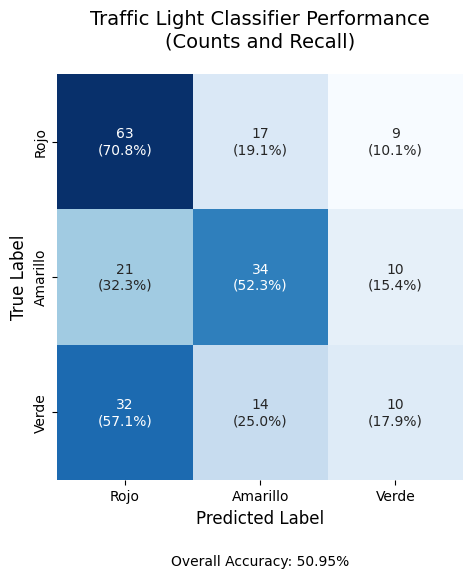

In [228]:
def enhanced_confusion_matrix(conf_matrix, class_names, model_name='Model'):
    """Enhanced version with additional metrics"""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Calculate percentages
    conf_matrix_perc = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotation labels with both counts and percentages
    annot_labels = np.array([
        [f"{count}\n({perc:.1f}%)" for count, perc in zip(row, row_perc)]
        for row, row_perc in zip(conf_matrix, conf_matrix_perc)
    ])
    
    sns.heatmap(conf_matrix_perc, annot=annot_labels, fmt='',
                xticklabels=class_names, yticklabels=class_names,
                cmap='Blues', cbar=False, square=True, ax=ax)
    
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title(f'{model_name} Performance\n(Counts and Recall)', fontsize=14, pad=20)
    
    # Add accuracy metrics
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    plt.text(0.5, -0.2, f"Overall Accuracy: {accuracy:.2%}",
             ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()

results = evaluate_predictions(df_predicted, test_values)
enhanced_confusion_matrix(results['confusion_matrix'], 
                         class_names=['Rojo','Amarillo', 'Verde'],
                         model_name='Traffic Light Classifier')


In [227]:
results

{'metrics': {'accuracy': 0.5095238095238095,
  'balanced_accuracy': 0.4698378400625592,
  'f1_weighted': 0.48513766482202636,
  'f1_macro': 0.4576683956884818,
  'coverage': 1.0},
 'high_conf_metrics': {'high_conf_accuracy': 0.6029411764705882,
  'high_conf_balanced_accuracy': 0.4913165266106443,
  'high_conf_f1_weighted': 0.5182896688086999,
  'high_conf_coverage': 0.3238095238095238},
 'confusion_matrix': array([[63, 17,  9],
        [21, 34, 10],
        [32, 14, 10]]),
 'classification_report': {'Amarillo': {'precision': 0.5431034482758621,
   'recall': 0.7078651685393258,
   'f1-score': 0.6146341463414634,
   'support': 89.0},
  'Rojo': {'precision': 0.5230769230769231,
   'recall': 0.5230769230769231,
   'f1-score': 0.5230769230769231,
   'support': 65.0},
  'Verde': {'precision': 0.3448275862068966,
   'recall': 0.17857142857142858,
   'f1-score': 0.23529411764705882,
   'support': 56.0},
  'accuracy': 0.5095238095238095,
  'macro avg': {'precision': 0.4703359858532272,
   'reca

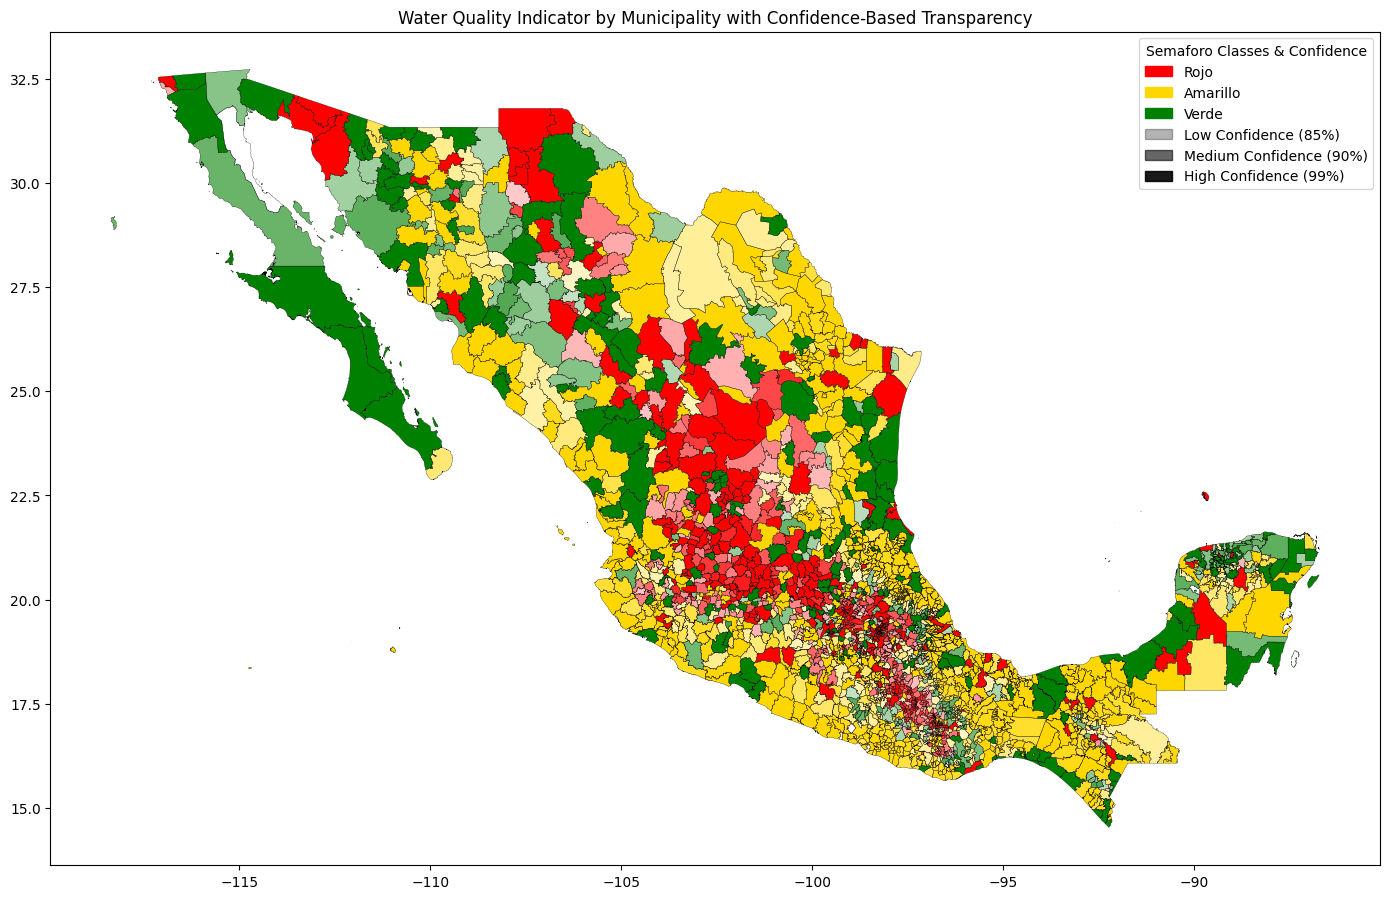

In [217]:
# Create alpha from confidence
scaler = MinMaxScaler(feature_range=(0.2, 1.0))
scaled_values = scaler.fit_transform(df_predicted[['confidence']])
df_predicted['scaled_confidence'] = scaled_values.flatten()
viz_on_map(df_predicted, alpha_col='scaled_confidence')

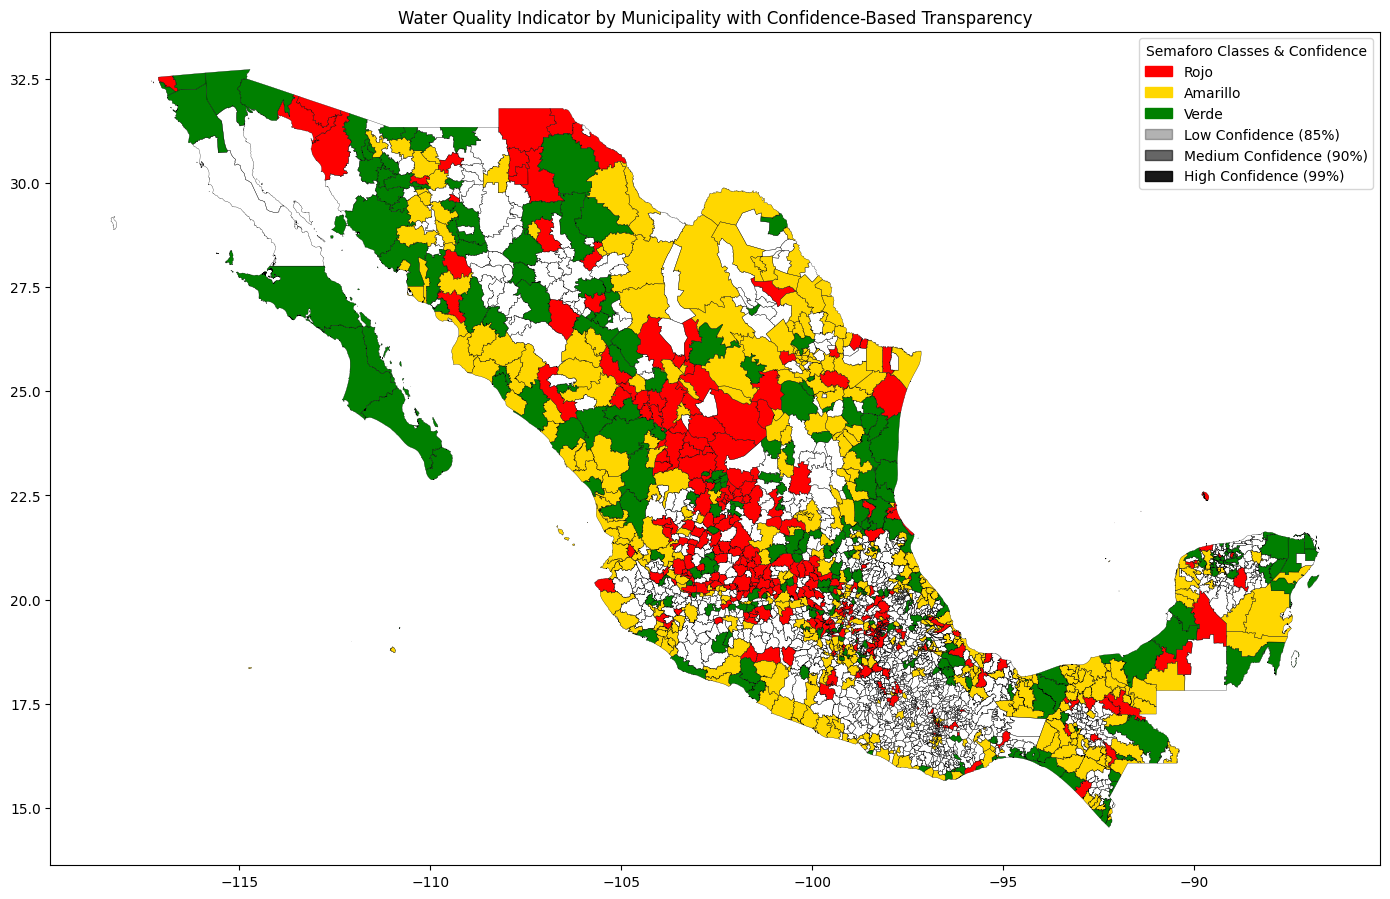

In [ ]:
# plot only real (not predicted) labels
real_labels = df_modified[df_modified['confidence']==1]
viz_on_map(real_labels)

In [55]:
df['semaforo'].notna()

CVEGEO
1001      True
1002      True
1003      True
1004      True
1005      True
         ...  
32054     True
32055     True
32056     True
32057     True
32058    False
Name: semaforo, Length: 2469, dtype: bool

In [ ]:
class MultiModelNaNClassifier:
    def __init__(self, models=None, model_confidence_threshold=0.60, 
                 label_prediction_threshold=0.85, max_iterations=5):
        """
        Multimodel Classifier for missing values 
        
        Args:
            models: List of classifier models
            model_confidence_threshold: Threshold for accepting ensemble predictions
            label_prediction_threshold: Threshold for keeping final predictions
            max_iterations: Maximum number of iterations
        """
        # Default: models for noisy data.
        if models is None:
            self.models = [
                CatBoostClassifier(iterations=500, class_weights={'Rojo': 0.31, 'Amarillo': 0.42, 'Verde': .27}, verbose=0),
                XGBClassifier(scale_pos_weight=2, max_depth=5, reg_alpha=1),
                RandomForestClassifier(max_samples=0.5, class_weight={'Rojo': 0.31, 'Amarillo': 0.42, 'Verde': .27})
            ]
        else:
            self.models = models
            
        self.model_confidence_threshold = model_confidence_threshold
        self.prediction_threshold = label_prediction_threshold
        self.max_iterations = max_iterations
        self.label_encoder = LabelEncoder()
        self.fitted_models = []
        
   
    def fit_models(self, X, y):
        """Fit all models on cleaned and scaled training data"""
        # Fit models
        self.fitted_models = []
        for model in self.models:
            try:
                model.fit(X, y) # y_clean removed
            except Exception as e:
                print(f"Error fitting {model.__class__.__name__}: {str(e)}")
                continue
            self.fitted_models.append(model)
    
    def predict_with_confidence(self, X):
        """
        Predict using average confidence of models.
        Returns predictions and confidence scores.
        """
        all_probs = []
        for model in self.fitted_models:
            try:
                proba = model.predict_proba(X)
                all_probs.append(proba)
            except Exception as e:
                print(f"Prediction error with {model.__class__.__name__}: {str(e)}")
                continue
                
        if not all_probs:
            raise ValueError("No models produced valid predictions")
        
        # Average probabilities across models
        avg_probs = np.mean(all_probs, axis=0)
        
        # Get predictions and confidence
        predictions = np.argmax(avg_probs, axis=1)
        confidence = np.max(avg_probs, axis=1)
        
        return predictions, confidence
    
    def process_dataframe(self, df, random_seed = 42):
        """
        Process the dataframe to predict NaN values in 'semaforo' column.
        Returns predicted dataframe and iteration count.
        """
        

        # use a df copy
        df_copy = df.copy()
        
        true_mask = df_copy['semaforo'].notna()
        # Encode labels
        self.label_encoder.fit(df_copy.loc[true_mask, 'semaforo'])

        # Prepare global validation data (20% of data is splitted)
        known_values_df = df_copy[true_mask].copy()
            
        # Stratified split to maintain class balance
        df_working, validation_df = train_test_split(
            known_values_df, 
            test_size=0.2, 
            random_state=random_seed-1,
            stratify=known_values_df['semaforo']
        )
        # Retain information of validation without labels.
        df_working = df_working.merge(validation_df.drop('semaforo'), how='outer', left_index=True, right_index=True)
        
        # Add confidence column and set known labels to 1.0
        df_working['confidence'] = np.where(
            df_working['semaforo'].notna(), 
            1.0,  # Full confidence for known labels
            np.nan  # NaN for unknown labels
        )
        
        # Track which rows need prediction
        predicted_mask = df_working['semaforo'].isna()
        iteration = 0
        
        while predicted_mask.any() and iteration < self.max_iterations:
            iteration += 1
            print(f"\nIteration {iteration}: There are still {predicted_mask.sum()} NaN values remaining")
            
            # Prepare internal validation data
            internal_validation_df = df_working[~predicted_mask].copy()
            
            # Stratified split to maintain class balance
            train_df, test_df = train_test_split(
                internal_validation_df,
                test_size=0.2, 
                random_state=random_seed + iteration,
                stratify=validation_df['semaforo']
            )
            
            # Prepare features and target
            X_train = train_df.drop(columns=['semaforo', 'confidence'], errors='ignore')
            y_train = self.label_encoder.transform(train_df['semaforo'])
            
            X_test = test_df.drop(columns=['semaforo', 'confidence'], errors='ignore')
            y_test = test_df['semaforo']
            
            # Fit models
            self.fit_models(X_train, y_train)
            
            # Predict on test set with confidence
            test_pred_encoded, test_conf = self.predict_with_confidence(X_test)
            test_pred = self.label_encoder.inverse_transform(test_pred_encoded)
            
            # Calculate robust metrics
            test_bal_acc = balanced_accuracy_score(y_test, test_pred)
            test_f1 = f1_score(y_test, test_pred, average='weighted')
            avg_confidence = np.mean(test_conf)
            
            print(f"Model'sTest Balanced Accuracy: {test_bal_acc:.2f}")
            print(f"Model's Test Weighted F1: {test_f1:.2f}")
            print(f"Model's Avg Confidence: {avg_confidence:.2f}")
            
            # Only proceed if confidence threshold is met
            if avg_confidence < self.model_confidence_threshold:
                print("Model's Average Confidence below threshold, stopping iteration")
                continue
                
            # Predict on NaN rows
            X_predict = df_working[predicted_mask].drop(
                columns=['semaforo', 'confidence'], 
                errors='ignore'
            )
            
            if not X_predict.empty:
                pred_encoded, pred_conf = self.predict_with_confidence(X_predict)
                pred_labels = self.label_encoder.inverse_transform(pred_encoded)
                
                # Update only high-confidence predictions
                high_conf_mask = pred_conf >= self.prediction_threshold
                
                if high_conf_mask.any():
                    # Update both the label and confidence
                    df_working.loc[predicted_mask, 'semaforo'] = np.where(
                        high_conf_mask,
                        pred_labels,
                        df_working.loc[predicted_mask, 'semaforo']
                    )
                    df_working.loc[predicted_mask, 'confidence'] = np.where(
                        high_conf_mask,
                        pred_conf,
                        df_working.loc[predicted_mask, 'confidence']
                    )
                
                # Update predicted mask
                predicted_mask = df_working['semaforo'].isna()
            else:
                print("No rows left to predict")
                
        # Final metrics
        num_predicted = (~df_working['semaforo'].isna() & (df_working['confidence'] < 1.0)).sum()
        avg_final_confidence = df_working.loc[df_working['confidence'] < 1.0, 'confidence'].mean()
        
        print(f"\nFinal Results:")
        print(f"- Predicted {num_predicted} values")
        print(f"- Average confidence of predictions: {avg_final_confidence:.2f}")
        
        if num_predicted > 0:
            # For evaluation, compare original known labels with current labels
            different_label_mask = validation_df['semaforo'] != df_working['semaforo']
            
            if different_label_mask.any():
                changed_count = different_label_mask.sum()
                change_accuracy = (validation_df['semaforo'][different_label_mask] == df_working['semaforo'][different_label_mask]).mean()
                print(f"- Changed {changed_count} original labels")
                print(f"- Mean Accuracy on changed labels: {change_accuracy:.2f}")
        
        return df_working, iteration

In [145]:
test_values

CVEGEO
21142        Rojo
14098        Rojo
24003       Verde
18005    Amarillo
20044       Verde
           ...   
7017     Amarillo
27003    Amarillo
13064        Rojo
19040    Amarillo
14101        Rojo
Name: semaforo, Length: 210, dtype: object

In [146]:
df_working.loc[21142]['semaforo']

nan

In [147]:
df_test, iterations_test = classifier.process_dataframe(df_working)

KeyError: "['semaforo'] not found in axis"

In [143]:

results = evaluate_predictions(predicted_df=df_modified,
                             test_values=test_values,
                            confidence_threshold=0.8)

KeyError: '[21142, 14098, 20044, 5026, 17005, 8002, 13062, 7089, 15060, 31011, 19012, 12011, 29049, 30211, 12053, 7102, 21194, 7012, 18001, 31090, 19025, 7079, 20421, 7101, 32027, 11002, 30117, 26009, 26021, 26001, 14045, 17012, 21090, 30073, 12055, 28021] not in index'

In [76]:
results

{'metrics': {'accuracy': 1.0,
  'balanced_accuracy': 1.0,
  'f1_weighted': 1.0,
  'f1_macro': 1.0,
  'coverage': 1.0},
 'high_conf_metrics': {'high_conf_accuracy': 1.0,
  'high_conf_balanced_accuracy': 1.0,
  'high_conf_f1_weighted': 1.0,
  'high_conf_coverage': 1.0},
 'confusion_matrix': array([[89,  0,  0],
        [ 0, 65,  0],
        [ 0,  0, 56]]),
 'classification_report': {'Amarillo': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 89.0},
  'Rojo': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 65.0},
  'Verde': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 56.0},
  'accuracy': 1.0,
  'macro avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 210.0},
  'weighted avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 210.0}}}

In [ ]:
# This multi model classifier predicts nan values from known values on a target column, 
# while it calculates metrics of confidence and keeps only predicted labels with > 0.90 average confidence. 
# Then it retrains itself with both known values and cofidently predicted values, until max iterations 
# is reached or there are no more values to predict. Finally it calculate milti-model metrics with a previosly subseted part of the known labels, including a confussion matrix.

class MultiModelNaNClassifier:
    def __init__(self, models=None, model_confidence_threshold=0.60, 
                 label_prediction_threshold=0.85, max_iterations=5):
        """
        Multimodel Classifier for missing values 
        
        Args:
            models: List of classifier models
            model_confidence_threshold: Threshold for accepting ensemble predictions
            label_prediction_threshold: Threshold for keeping final predictions
            max_iterations: Maximum number of iterations
        """
        # Default: models for noisy data.
        if models is None:
            self.models = [
                CatBoostClassifier(iterations=500, class_weights={'Rojo': 0.31, 'Amarillo': 0.42, 'Verde': .27}, verbose=0),
                XGBClassifier(scale_pos_weight=2, max_depth=5, reg_alpha=1),
                RandomForestClassifier(max_samples=0.5, class_weight={'Rojo': 0.31, 'Amarillo': 0.42, 'Verde': .27})
            ]
        else:
            self.models = models
            
        self.model_confidence_threshold = model_confidence_threshold
        self.prediction_threshold = label_prediction_threshold
        self.max_iterations = max_iterations
        self.label_encoder = LabelEncoder()
        self.fitted_models = []
        
   
    def fit_models(self, X, y):
        """Fit all models on cleaned and scaled training data"""
        # Fit models
        self.fitted_models = []
        for model in self.models:
            try:
                model.fit(X, y) # y_clean removed
            except Exception as e:
                print(f"Error fitting {model.__class__.__name__}: {str(e)}")
                continue
            self.fitted_models.append(model)
    
    def predict_with_confidence(self, X):
        """
        Predict using average confidence of models.
        Returns predictions and confidence scores.
        """
        all_probs = []
        for model in self.fitted_models:
            try:
                proba = model.predict_proba(X)
                all_probs.append(proba)
            except Exception as e:
                print(f"Prediction error with {model.__class__.__name__}: {str(e)}")
                continue
                
        if not all_probs:
            raise ValueError("No models produced valid predictions")
        
        # Average probabilities across models
        avg_probs = np.mean(all_probs, axis=0)
        
        # Get predictions and confidence
        predictions = np.argmax(avg_probs, axis=1)
        confidence = np.max(avg_probs, axis=1)
        
        return predictions, confidence
    
    def process_dataframe(self, df, random_seed = 42):
        """
        Process the dataframe to predict NaN values in 'semaforo' column.
        Returns predicted dataframe and iteration count.
        """
        

        # use a df copy
        df_copy = df.copy()
        
        true_mask = df_copy['semaforo'].notna()
        # Encode labels
        self.label_encoder.fit(df_copy.loc[true_mask, 'semaforo'])

        # Prepare global validation data (20% of data is splitted)
        known_values_df = df_copy[true_mask].copy()
            
        # Stratified split to maintain class balance
        df_working, validation_df = train_test_split(
            known_values_df, 
            test_size=0.2, 
            random_state=random_seed-1,
            stratify=known_values_df['semaforo']
        )
        # Retain information of validation without labels.
        df_working = df_working.merge(validation_df.drop('semaforo'), how='outer', left_index=True, right_index=True)
        
        # Add confidence column and set known labels to 1.0
        df_working['confidence'] = np.where(
            df_working['semaforo'].notna(), 
            1.0,  # Full confidence for known labels
            np.nan  # NaN for unknown labels
        )
        
        # Track which rows need prediction
        predicted_mask = df_working['semaforo'].isna()
        iteration = 0
        
        while predicted_mask.any() and iteration < self.max_iterations:
            iteration += 1
            print(f"\nIteration {iteration}: There are still {predicted_mask.sum()} NaN values remaining")
            
            # Prepare internal validation data
            internal_validation_df = df_working[~predicted_mask].copy()
            
            # Stratified split to maintain class balance
            train_df, test_df = train_test_split(
                internal_validation_df,
                test_size=0.2, 
                random_state=random_seed + iteration,
                stratify=validation_df['semaforo']
            )
            
            # Prepare features and target
            X_train = train_df.drop(columns=['semaforo', 'confidence'], errors='ignore')
            y_train = self.label_encoder.transform(train_df['semaforo'])
            
            X_test = test_df.drop(columns=['semaforo', 'confidence'], errors='ignore')
            y_test = test_df['semaforo']
            
            # Fit models
            self.fit_models(X_train, y_train)
            
            # Predict on test set with confidence
            test_pred_encoded, test_conf = self.predict_with_confidence(X_test)
            test_pred = self.label_encoder.inverse_transform(test_pred_encoded)
            
            # Calculate robust metrics
            test_bal_acc = balanced_accuracy_score(y_test, test_pred)
            test_f1 = f1_score(y_test, test_pred, average='weighted')
            avg_confidence = np.mean(test_conf)
            
            print(f"Model'sTest Balanced Accuracy: {test_bal_acc:.2f}")
            print(f"Model's Test Weighted F1: {test_f1:.2f}")
            print(f"Model's Avg Confidence: {avg_confidence:.2f}")
            
            # Only proceed if confidence threshold is met
            if avg_confidence < self.model_confidence_threshold:
                print("Model's Average Confidence below threshold, stopping iteration")
                continue
                
            # Predict on NaN rows
            X_predict = df_working[predicted_mask].drop(
                columns=['semaforo', 'confidence'], 
                errors='ignore'
            )
            
            if not X_predict.empty:
                pred_encoded, pred_conf = self.predict_with_confidence(X_predict)
                pred_labels = self.label_encoder.inverse_transform(pred_encoded)
                
                # Update only high-confidence predictions
                high_conf_mask = pred_conf >= self.prediction_threshold
                
                if high_conf_mask.any():
                    # Update both the label and confidence
                    df_working.loc[predicted_mask, 'semaforo'] = np.where(
                        high_conf_mask,
                        pred_labels,
                        df_working.loc[predicted_mask, 'semaforo']
                    )
                    df_working.loc[predicted_mask, 'confidence'] = np.where(
                        high_conf_mask,
                        pred_conf,
                        df_working.loc[predicted_mask, 'confidence']
                    )
                
                # Update predicted mask
                predicted_mask = df_working['semaforo'].isna()
            else:
                print("No rows left to predict")
                
        # Final metrics
        num_predicted = (~df_working['semaforo'].isna() & (df_working['confidence'] < 1.0)).sum()
        avg_final_confidence = df_working.loc[df_working['confidence'] < 1.0, 'confidence'].mean()
        
        print(f"\nFinal Results:")
        print(f"- Predicted {num_predicted} values")
        print(f"- Average confidence of predictions: {avg_final_confidence:.2f}")
        
        if num_predicted > 0:
            # For evaluation, compare original known labels with current labels
            different_label_mask = validation_df['semaforo'] != df_working['semaforo']
            
            if different_label_mask.any():
                changed_count = different_label_mask.sum()
                change_accuracy = (validation_df['semaforo'][different_label_mask] == df_working['semaforo'][different_label_mask]).mean()
                print(f"- Changed {changed_count} original labels")
                print(f"- Mean Accuracy on changed labels: {change_accuracy:.2f}")
        
        return df_working, iteration

In [133]:
# After running the classifier
classifier = MultiModelNaNClassifier()
result_df, iterations, metrics = classifier.process_dataframe(df)

# Access specific metrics
print(f"Final Balanced Accuracy: {metrics['balanced_accuracy']:.2f}")
print("Confusion Matrix:")
print(metrics['confusion_matrix'])

KeyError: "['semaforo'] not found in axis"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

class MultiModelNaNClassifier:
    def __init__(self, models=None, model_confidence_threshold=0.60, 
                 label_prediction_threshold=0.90, max_iterations=20, 
                 validation_split=0.15, random_state=42):
        """
        A multi-model classifier for predicting NaN values in categorical target columns.
        
        Args:
            models: List of classifier models (default: CatBoost, XGBoost, RandomForest)
            model_confidence_threshold: Minimum confidence for model predictions
            label_prediction_threshold: Minimum average confidence for label acceptance
            max_iterations: Maximum iterations for the prediction loop
            validation_split: Fraction of data to hold out for validation
            random_state: Random seed for reproducibility
        """
        self.models = models or self._get_default_models()
        self.model_confidence_threshold = model_confidence_threshold
        self.prediction_threshold = label_prediction_threshold
        self.max_iterations = max_iterations
        self.validation_split = validation_split
        self.random_state = random_state
        self.label_encoder = LabelEncoder()
        self.validation_set = None
        self.class_weights_ = None
        
    def _get_default_models(self):
        """Return default set of models with balanced class handling"""
        return [
            CatBoostClassifier(iterations=500, verbose=0, class_weights=self.class_weights_),
            XGBClassifier(max_depth=5, reg_alpha=1, scale_pos_weight='balanced'),
            RandomForestClassifier(max_samples=0.5, class_weight='balanced_subsample')
        ]
    
    def _compute_class_weights(self, y):
        """Calculate balanced class weights based on label distribution"""
        classes = np.unique(y)
        weights = compute_class_weight('balanced', classes=classes, y=y)
        return dict(zip(classes, weights))
    
    def fit_models(self, X, y):
        """Fit all models on training data with proper label handling"""
        y_encoded = self.label_encoder.transform(y)
        
        if self.class_weights_ is None:
            self.class_weights_ = self._compute_class_weights(y_encoded)
        
        for model in self.models:
            try:
                if isinstance(model, CatBoostClassifier):
                    # Update class weights for CatBoost
                    model.set_params(class_weights=self.class_weights_)
                    model.fit(X, y, verbose=False)  # CatBoost handles strings directly
                elif isinstance(model, XGBClassifier):
                    # Handle class imbalance for XGBoost
                    model.fit(X, y_encoded, 
                             sample_weight=np.array([self.class_weights_[x] for x in y_encoded]))
                else:
                    # For other models (like RandomForest)
                    model.fit(X, y_encoded)
            except Exception as e:
                print(f"Error fitting {model.__class__.__name__}: {e}")
    
    def predict_with_confidence(self, X):
        """Get ensemble predictions and confidence scores"""
        probas = []
        for model in self.models:
            try:
                proba = model.predict_proba(X)
                if isinstance(model, CatBoostClassifier) and not np.array_equal(model.classes_, self.label_encoder.classes_):
                    order = [np.where(model.classes_ == cls)[0][0] for cls in self.label_encoder.classes_]
                    proba = proba[:, order]
                probas.append(proba)
            except Exception as e:
                print(f"Prediction error with {model.__class__.__name__}: {e}")
        
        avg_probs = np.mean(probas, axis=0)
        predictions = np.argmax(avg_probs, axis=1)
        confidence = np.max(avg_probs, axis=1)
        
        return predictions, confidence
    
    def _plot_confusion_matrix(self, y_true, y_pred):
        """Plot styled confusion matrix with percentages"""
        classes = self.label_encoder.classes_
        cm = confusion_matrix(y_true, y_pred, labels=classes)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
                   xticklabels=classes, yticklabels=classes,
                   cbar=False, square=True)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix (% of True Labels)')
        plt.show()
        return cm
    
    def _evaluate_validation(self):
        """Evaluate performance on validation set and return metrics"""
        X_val = self.validation_set.drop(columns=['semaforo'], errors='ignore')
        y_val_true = self.validation_set['semaforo']
        
        val_pred, val_conf = self.predict_with_confidence(X_val)
        val_pred = self.label_encoder.inverse_transform(val_pred)
        
        metrics = {
            'balanced_accuracy': balanced_accuracy_score(y_val_true, val_pred),
            'f1_score': f1_score(y_val_true, val_pred, average='weighted'),
            'average_confidence': np.mean(val_conf),
            'confusion_matrix': confusion_matrix(y_val_true, val_pred)
        }
        
        print(f"\n{' Final Validation Metrics ':-^50}")
        print(f"Balanced Accuracy: {metrics['balanced_accuracy']:.2f}")
        print(f"Weighted F1 Score: {metrics['f1_score']:.2f}")
        print(f"Average Confidence: {metrics['average_confidence']:.2f}")
        
        self._plot_confusion_matrix(y_val_true, val_pred)
        return metrics
    
    def process_dataframe(self, df, target_col='semaforo'):
        """
        Predict missing target values iteratively.
        
        Args:
            df: Input DataFrame containing features and target column
            target_col: Name of the target column with missing values
            
        Returns:
            Tuple of (processed DataFrame, iterations used, validation metrics)
        """
        df = df.copy()
        known_mask = df[target_col].notna()
        
        # Initialize label encoder and validation set
        self.label_encoder.fit(df.loc[known_mask, target_col])
        train_df, self.validation_set = train_test_split(
            df[known_mask],
            test_size=self.validation_split,
            random_state=self.random_state,
            stratify=df.loc[known_mask, target_col]
        )
        
        # Initialize working dataset with confidence tracking
        df_working = pd.concat([train_df, df[~known_mask]])
        # Fix the length mismatch by using the index of df_working
        df_working['confidence'] = np.where(df_working.index.isin(train_df.index), 1.0, np.nan)
        
        # Iterative prediction loop
        for iteration in range(self.max_iterations):
            missing_mask = df_working[target_col].isna()
            if not missing_mask.any():
                break
                
            print(f"\nIteration {iteration+1}: {missing_mask.sum()} missing values")
            
            # Train models on current known values
            train_data = df_working[~missing_mask]
            X_train = train_data.drop(columns=[target_col, 'confidence'], errors='ignore')
            y_train = train_data[target_col]
            self.fit_models(X_train, y_train)
            
            # Predict missing values
            X_missing = df_working[missing_mask].drop(columns=[target_col, 'confidence'], errors='ignore')
            pred, conf = self.predict_with_confidence(X_missing)
            pred = self.label_encoder.inverse_transform(pred)
            
            # Update high-confidence predictions
            high_conf = conf >= self.prediction_threshold
            df_working.loc[missing_mask, target_col] = np.where(high_conf, pred, np.nan)
            df_working.loc[missing_mask, 'confidence'] = np.where(high_conf, conf, np.nan)
        
        # Calculate and display prediction stats
        predicted = df_working['confidence'].between(0, 1).sum()
        avg_conf = df_working.loc[df_working['confidence'] < 1, 'confidence'].mean()
        print(f"\nPredicted {predicted} missing values")
        print(f"Average prediction confidence: {avg_conf:.2f}")
        
        # Evaluate on validation set if available
        val_metrics = self._evaluate_validation() if self.validation_set is not None else None
        
        return df_working, iteration + 1, val_metrics

In [131]:
# After running the classifier
classifier = MultiModelNaNClassifier()
result_df, iterations, metrics = classifier.process_dataframe(df)



ValueError: Length of values (2469) does not match length of index (2312)